In [31]:
!pip install PyWavelets
!pip install xgboost
!pip install tensorflow
!pip install scikit-learn

In [32]:
import pandas as pd
import numpy as np
from datetime import datetime
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from keras.callbacks import EarlyStopping
import pywt
from scipy.fft import fft
from keras.models import Sequential

In [33]:
file_path= '/content/battery_concat.csv'
data=pd.read_csv(file_path, delimiter=',')

In [34]:
data.head()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Kurtosis Index,Capacity,SoC,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation
0,5,1,4.191492,24,-0.004902,24.330034,-0.0006,0.000,0.000,0.179017,...,4.309881,1.862443,93.12215,-0.002451,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.242294
1,5,1,4.190749,24,-0.001478,24.325993,-0.0006,4.206,16.781,0.179017,...,4.309881,1.862443,93.12215,-0.000739,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.246335
2,5,1,3.974871,24,-2.012528,24.389085,-1.9982,3.062,35.703,0.179017,...,4.309881,1.862443,93.12215,-1.006264,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.183243
3,5,1,3.951717,24,-2.013979,24.544752,-1.9982,3.030,53.781,0.179017,...,4.309881,1.862443,93.12215,-1.006990,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.027576
4,5,1,3.934352,24,-2.011144,24.731385,-1.9982,3.011,71.922,0.179017,...,4.309881,1.862443,93.12215,-1.005572,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-7.840943


In [35]:
data.tail()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Kurtosis Index,Capacity,SoC,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation
185716,18,132,3.443760,24,-0.002426,35.383979,0.0006,0.0,2686.359,0.201349,...,4.765971,1.360302,68.015082,-0.001213,-1.360302,-0.000282,1.820179,347.979961,-6.143808,4.107734
185717,18,132,3.453271,24,-0.000981,35.179732,0.0006,0.0,2700.546,0.201349,...,4.765971,1.360302,68.015082,-0.000491,-1.360302,-0.000282,1.820179,347.979961,-6.143808,3.903487
185718,18,132,3.461963,24,0.000209,34.977000,0.0006,0.0,2714.640,0.201349,...,4.765971,1.360302,68.015082,0.000104,-1.360302,-0.000282,1.820179,347.979961,-6.143808,3.700755
185719,18,132,3.469907,24,0.001516,34.785943,0.0006,0.0,2728.750,0.201349,...,4.765971,1.360302,68.015082,0.000758,-1.360302,-0.000282,1.820179,347.979961,-6.143808,3.509698
185720,18,132,3.477277,24,-0.001940,34.581660,0.0006,0.0,2742.843,0.201349,...,4.765971,1.360302,68.015082,-0.000970,-1.360302,-0.000282,1.820179,347.979961,-6.143808,3.305415


In [36]:
data.shape

(185721, 21)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185721 entries, 0 to 185720
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Battery_id             185721 non-null  int64  
 1   Cycle Number           185721 non-null  int64  
 2   Voltage                185721 non-null  float64
 3   Ambient temp           185721 non-null  int64  
 4   Current                185721 non-null  float64
 5   Temperature            185721 non-null  float64
 6   Current Load           185721 non-null  float64
 7   Voltage Load           185721 non-null  float64
 8   Time                   185721 non-null  float64
 9   Fluctuation Index      185721 non-null  float64
 10  Skewness Index         185721 non-null  float64
 11  Kurtosis Index         185721 non-null  float64
 12  Capacity               185721 non-null  float64
 13  SoC                    185721 non-null  float64
 14  Discharge Rate         185721 non-nu

In [38]:
data.describe()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Kurtosis Index,Capacity,SoC,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation
count,185721.000000,185721.000000,185721.000000,185721.0,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,...,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,1.857210e+05
mean,8.252799,82.838758,3.497219,24.0,-1.832569,32.378997,1.465434,2.366494,1546.379935,0.230871,...,5.510653,1.587423,79.371172,-0.916284,-1.587423,-0.000230,1.799526,-74.273992,-6.420762,-5.478633e-17
std,4.743428,45.692247,0.251691,0.0,0.561405,4.027737,1.226874,0.751377,906.958628,0.023214,...,1.795029,0.190001,9.500073,0.280702,0.190001,0.000041,0.220695,2608.931740,0.450070,3.908556e+00
min,5.000000,1.000000,1.737030,24.0,-2.029098,22.350256,-2.000000,0.000000,0.000000,0.161813,...,3.528155,1.172439,58.621975,-1.014549,-2.041423,-0.000308,1.493270,-20707.349523,-7.103982,-9.866722e+00
25%,5.000000,45.000000,3.377653,24.0,-2.011418,29.570621,1.998200,2.410000,764.797000,0.220286,...,4.304409,1.439171,71.958571,-1.005709,-1.752563,-0.000253,1.586603,-227.099963,-6.777915,-2.709754e+00
50%,6.000000,81.000000,3.500859,24.0,-2.009015,32.355737,1.998800,2.558000,1537.031000,0.230603,...,4.741659,1.567892,78.394616,-1.004508,-1.567892,-0.000226,1.757973,-65.330717,-6.501760,9.984370e-02
75%,7.000000,120.000000,3.655751,24.0,-1.989974,35.420677,1.999000,2.718000,2307.485000,0.247784,...,6.217468,1.752563,87.628142,-0.994987,-1.439171,-0.000214,2.015958,25.013362,-6.125274,3.015451e+00
max,18.000000,168.000000,4.233325,24.0,0.014306,42.332522,2.000000,4.249000,3690.234000,0.272858,...,14.796169,2.041423,102.071146,0.007153,-1.172439,-0.000068,2.459612,38750.363218,-5.076706,8.735434e+00


In [39]:
data=data.dropna()
missing_values=data.isnull().sum()
print(missing_values[missing_values>0])

Series([], dtype: int64)


In [40]:
duplicates=data.duplicated()
print(data[duplicates])

Empty DataFrame
Columns: [Battery_id, Cycle Number, Voltage, Ambient temp, Current, Temperature, Current Load, Voltage Load, Time, Fluctuation Index, Skewness Index, Kurtosis Index, Capacity, SoC, Discharge Rate, Energy, Battery Voltage Slope, Voltage Range, Battery Impedance, Power, Temperature Deviation]
Index: []

[0 rows x 21 columns]


In [41]:
data = data.drop(columns=['SoC'])

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185721 entries, 0 to 185720
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Battery_id             185721 non-null  int64  
 1   Cycle Number           185721 non-null  int64  
 2   Voltage                185721 non-null  float64
 3   Ambient temp           185721 non-null  int64  
 4   Current                185721 non-null  float64
 5   Temperature            185721 non-null  float64
 6   Current Load           185721 non-null  float64
 7   Voltage Load           185721 non-null  float64
 8   Time                   185721 non-null  float64
 9   Fluctuation Index      185721 non-null  float64
 10  Skewness Index         185721 non-null  float64
 11  Kurtosis Index         185721 non-null  float64
 12  Capacity               185721 non-null  float64
 13  Discharge Rate         185721 non-null  float64
 14  Energy                 185721 non-nu

In [43]:
data['SoC'] = data['Capacity'] / data.groupby('Battery_id')['Capacity'].transform('max') * 100


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185721 entries, 0 to 185720
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Battery_id             185721 non-null  int64  
 1   Cycle Number           185721 non-null  int64  
 2   Voltage                185721 non-null  float64
 3   Ambient temp           185721 non-null  int64  
 4   Current                185721 non-null  float64
 5   Temperature            185721 non-null  float64
 6   Current Load           185721 non-null  float64
 7   Voltage Load           185721 non-null  float64
 8   Time                   185721 non-null  float64
 9   Fluctuation Index      185721 non-null  float64
 10  Skewness Index         185721 non-null  float64
 11  Kurtosis Index         185721 non-null  float64
 12  Capacity               185721 non-null  float64
 13  Discharge Rate         185721 non-null  float64
 14  Energy                 185721 non-nu

In [45]:
data.describe()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Kurtosis Index,Capacity,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation,SoC
count,185721.000000,185721.000000,185721.000000,185721.0,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,...,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,1.857210e+05,185721.000000
mean,8.252799,82.838758,3.497219,24.0,-1.832569,32.378997,1.465434,2.366494,1546.379935,0.230871,...,5.510653,1.587423,-0.916284,-1.587423,-0.000230,1.799526,-74.273992,-6.420762,-5.478633e-17,82.510163
std,4.743428,45.692247,0.251691,0.0,0.561405,4.027737,1.226874,0.751377,906.958628,0.023214,...,1.795029,0.190001,0.280702,0.190001,0.000041,0.220695,2608.931740,0.450070,3.908556e+00,10.484294
min,5.000000,1.000000,1.737030,24.0,-2.029098,22.350256,-2.000000,0.000000,0.000000,0.161813,...,3.528155,1.172439,-1.014549,-2.041423,-0.000308,1.493270,-20707.349523,-7.103982,-9.866722e+00,57.432464
25%,5.000000,45.000000,3.377653,24.0,-2.011418,29.570621,1.998200,2.410000,764.797000,0.220286,...,4.304409,1.439171,-1.005709,-1.752563,-0.000253,1.586603,-227.099963,-6.777915,-2.709754e+00,74.787851
50%,6.000000,81.000000,3.500859,24.0,-2.009015,32.355737,1.998800,2.558000,1537.031000,0.230603,...,4.741659,1.567892,-1.004508,-1.567892,-0.000226,1.757973,-65.330717,-6.501760,9.984370e-02,82.131464
75%,7.000000,120.000000,3.655751,24.0,-1.989974,35.420677,1.999000,2.718000,2307.485000,0.247784,...,6.217468,1.752563,-0.994987,-1.439171,-0.000214,2.015958,25.013362,-6.125274,3.015451e+00,91.770235
max,18.000000,168.000000,4.233325,24.0,0.014306,42.332522,2.000000,4.249000,3690.234000,0.272858,...,14.796169,2.041423,0.007153,-1.172439,-0.000068,2.459612,38750.363218,-5.076706,8.735434e+00,100.000000


In [46]:
data.head()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Kurtosis Index,Capacity,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation,SoC
0,5,1,4.191492,24,-0.004902,24.330034,-0.0006,0.000,0.000,0.179017,...,4.309881,1.862443,-0.002451,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.242294,100.0
1,5,1,4.190749,24,-0.001478,24.325993,-0.0006,4.206,16.781,0.179017,...,4.309881,1.862443,-0.000739,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.246335,100.0
2,5,1,3.974871,24,-2.012528,24.389085,-1.9982,3.062,35.703,0.179017,...,4.309881,1.862443,-1.006264,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.183243,100.0
3,5,1,3.951717,24,-2.013979,24.544752,-1.9982,3.030,53.781,0.179017,...,4.309881,1.862443,-1.006990,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.027576,100.0
4,5,1,3.934352,24,-2.011144,24.731385,-1.9982,3.011,71.922,0.179017,...,4.309881,1.862443,-1.005572,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-7.840943,100.0


In [47]:
columns_to_compare = ['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
        'Discharge Rate', 'Energy', 'Battery Voltage Slope',
       'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation']
for column in columns_to_compare:
    correlation = data[column].corr(data['SoC'])
    print(f'Correlation coefficient between {column} and SoC: {correlation:.2f}')

Correlation coefficient between Battery_id and SoC: 0.15
Correlation coefficient between Cycle Number and SoC: -0.89
Correlation coefficient between Voltage and SoC: 0.18
Correlation coefficient between Ambient temp and SoC: nan
Correlation coefficient between Current and SoC: -0.16
Correlation coefficient between Temperature and SoC: -0.15
Correlation coefficient between Current Load and SoC: -0.33
Correlation coefficient between Voltage Load and SoC: 0.22
Correlation coefficient between Time and SoC: 0.11
Correlation coefficient between Fluctuation Index and SoC: -0.20
Correlation coefficient between Skewness Index and SoC: -0.53
Correlation coefficient between Kurtosis Index and SoC: 0.53
Correlation coefficient between Capacity and SoC: 0.96
Correlation coefficient between Discharge Rate and SoC: -0.16
Correlation coefficient between Energy and SoC: -0.96
Correlation coefficient between Battery Voltage Slope and SoC: -0.28
Correlation coefficient between Voltage Range and SoC: 0.19

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [48]:
data.columns

Index(['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'Discharge Rate', 'Energy', 'Battery Voltage Slope', 'Voltage Range',
       'Battery Impedance', 'Power', 'Temperature Deviation', 'SoC'],
      dtype='object')

In [21]:
pip install --upgrade xgboost scikit-learn


In [22]:
from xgboost import XGBRegressor

In [49]:
data.shape

(185721, 21)

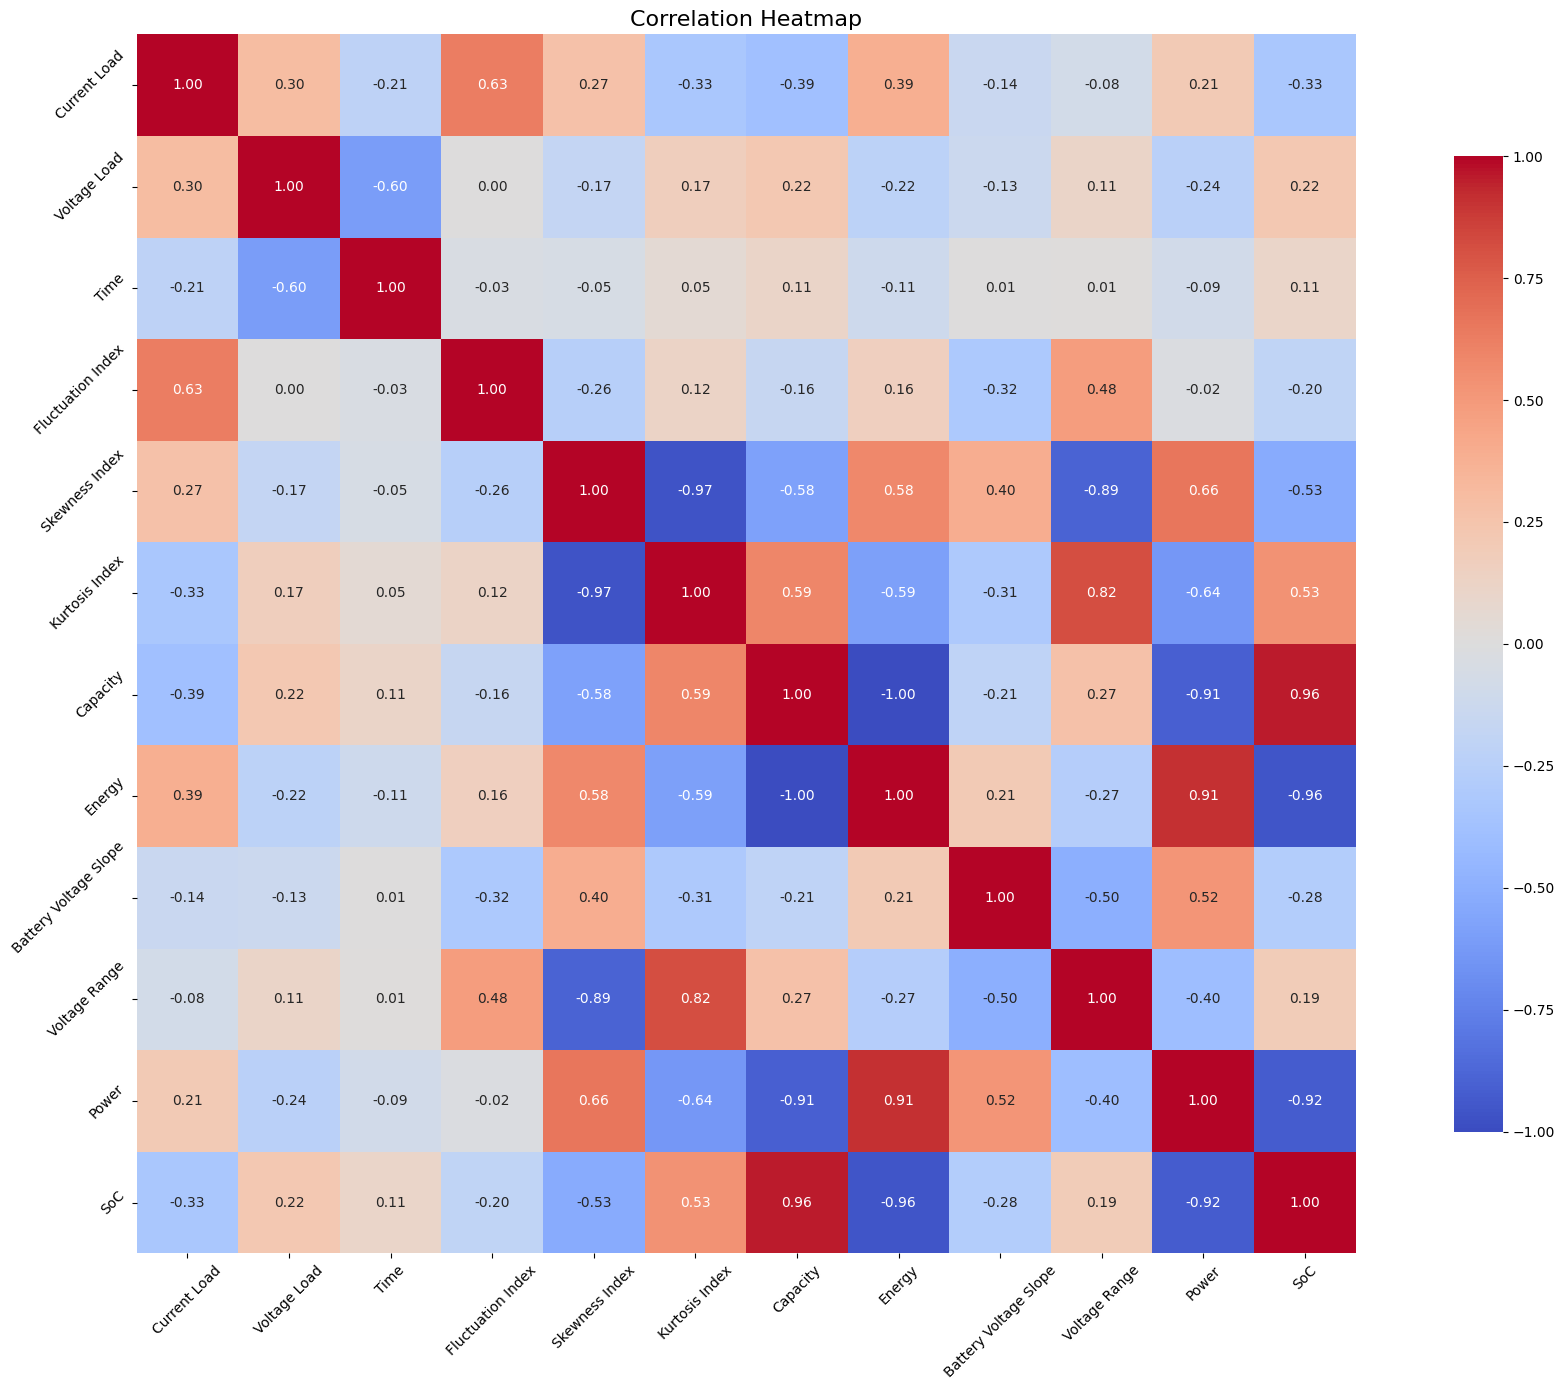

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
# Replace with your actual data loading process
# data = pd.read_csv('your_battery_data.csv')

# Prepare your input features
input_data = data[['Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
        'Energy', 'Battery Voltage Slope',
       'Voltage Range',  'Power', 'SoC']]

# Calculate the correlation matrix
correlation_matrix = input_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 14))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add title and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Epoch 1/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1042.3301 - mae: 17.0886
Epoch 2/15
  42/2902 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 327.7118 - mae: 4.9859

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


2902/2902 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 326.4087 - mae: 4.8457
Epoch 3/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 325.6525 - mae: 4.5217
Epoch 4/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 324.7953 - mae: 4.3971
Epoch 5/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 324.9539 - mae: 4.3202
Epoch 6/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 324.5895 - mae: 4.2673
Epoch 7/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 324.4926 - mae: 4.2330
Epoch 8/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 324.4349 - mae: 4.2216
Epoch 9/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 324.3000 - mae: 4.2103
Epoch 10/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 324.6627 - mae: 4.1925
Epoch 11/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 324.6276 - mae: 4.1778
Epoch 12/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 324.5323 - mae: 4.1769
Epoch 13/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 324.3494 

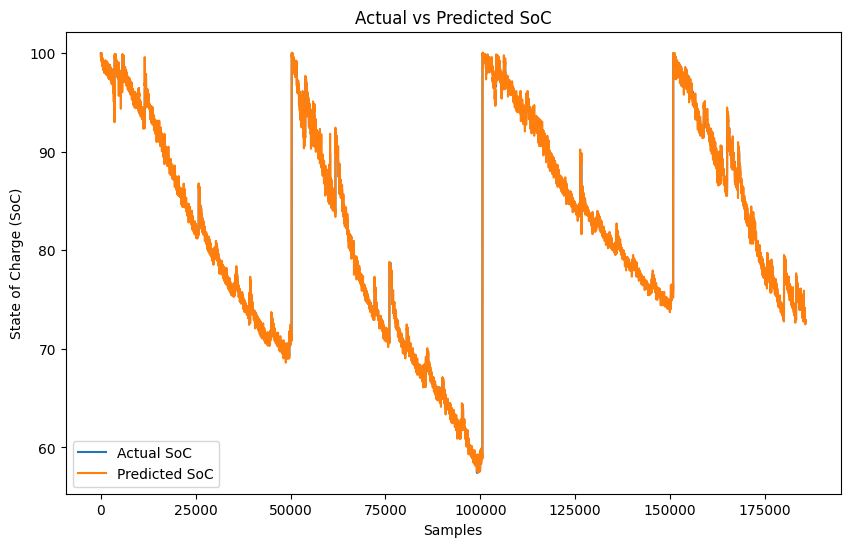

In [51]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is already loaded and preprocessed
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power',
            'Temperature Deviation', 'Time']

# Replace 'RUL' with 'SoC'
X = data[features].values
y = data['SoC'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Number of time steps for sequence creation
time_steps = 10

# Function to create sequences
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(time_steps, X_seq.shape[2])),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train CNN model
cnn_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

# Extract CNN features for XGBoost
X_cnn_features = cnn_model.predict(X_seq)

# Train XGBoost model on CNN features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_cnn_features, y_seq)

# Predict SoC
y_pred = xgb_model.predict(X_cnn_features)

# Evaluating the performance
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE) for SoC prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# Actual vs predicted SoC plot
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual SoC')
plt.plot(y_pred, label='Predicted SoC')
plt.title('Actual vs Predicted SoC')
plt.xlabel('Samples')
plt.ylabel('State of Charge (SoC)')
plt.legend()
plt.show()


Epoch 1/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1343.4147 - mae: 21.3276 - val_loss: 436.3904 - val_mae: 6.7484
Epoch 2/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 436.0772 - mae: 6.5034 - val_loss: 433.3431 - val_mae: 5.9781
Epoch 3/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 434.0912 - mae: 5.9625 - val_loss: 432.8676 - val_mae: 5.7975
Epoch 4/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 433.9474 - mae: 5.7880 - val_loss: 432.5023 - val_mae: 5.6471
Epoch 5/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 432.9239 - mae: 5.7176 - val_loss: 432.4434 - val_mae: 5.6385
Epoch 6/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 433.1582 - mae: 5.6641 - val_loss: 432.7216 - val_mae: 5.8356
Epoch 7/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 432.6984 - mae: 5.6449 - val_loss: 432.2962 - val_mae: 5.5705
Epoch 8/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 432.8025 - mae: 5.6130 - val_loss: 432.5185 - val_mae: 5.6546
Epoch 

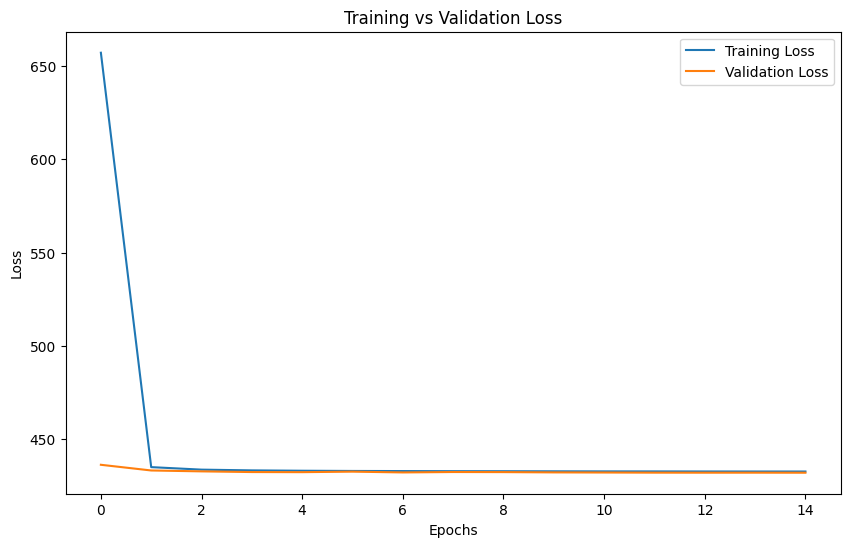

4063/4063 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
871/871 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Validation Set Metrics:
Mean Absolute Error (MAE): 0.30547341197690997
Mean Squared Error (MSE): 0.20628722588813053
Root Mean Squared Error (RMSE): 0.4541885356194391
R² (Coefficient of Determination): 0.998104068106457
Test Set Metrics:
Mean Absolute Error (MAE): 0.30673292702417887
Mean Squared Error (MSE): 0.22042908029699257
Root Mean Squared Error (RMSE): 0.46949875430824367
R² (Coefficient of Determination): 0.997983045764908


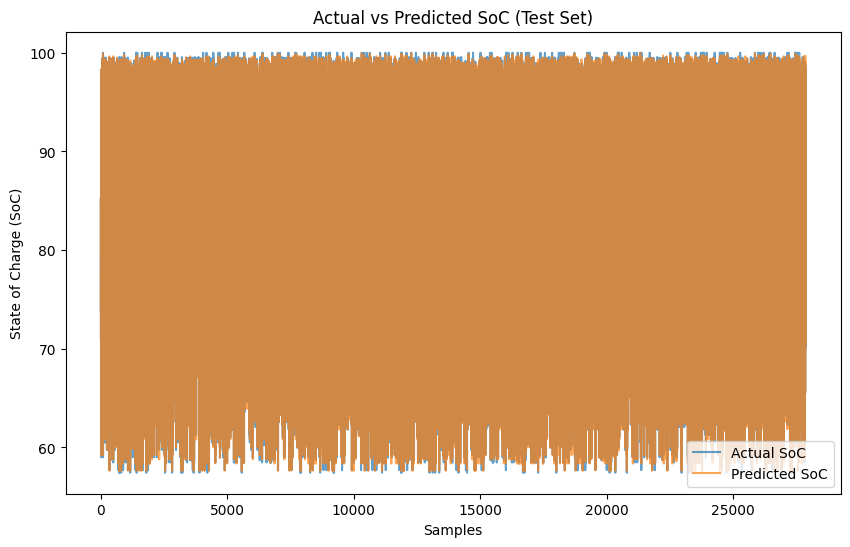

In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to create sequences
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']

X = data[features].values
y = data['SoC'].values  # Change target to SoC

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Number of time steps for sequence creation
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# CNN model
cnn_model = models.Sequential([
    Input(shape=(time_steps, X_seq.shape[2])),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Flatten(),  # Ensure the output is 1D
    layers.Dense(64, activation='relu'),
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the CNN model
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract CNN features from the training, validation, and test sets
X_train_cnn = cnn_model.predict(X_train)
X_val_cnn = cnn_model.predict(X_val)
X_test_cnn = cnn_model.predict(X_test)

# Train XGBoost model on CNN-extracted training features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_train_cnn, y_train)

# Evaluate on validation and test sets to check for overfitting
y_val_pred = xgb_model.predict(X_val_cnn)
y_test_pred = xgb_model.predict(X_test_cnn)

# Metrics for validation set
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Set Metrics:')
print(f'Mean Absolute Error (MAE): {val_mae}')
print(f'Mean Squared Error (MSE): {val_mse}')
print(f'Root Mean Squared Error (RMSE): {val_rmse}')
print(f'R² (Coefficient of Determination): {val_r2}')

# Metrics for test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Set Metrics:')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Root Mean Squared Error (RMSE): {test_rmse}')
print(f'R² (Coefficient of Determination): {test_r2}')

# Plot actual vs predicted SoC for test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual SoC', alpha=0.7)
plt.plot(y_test_pred, label='Predicted SoC', alpha=0.7)
plt.title('Actual vs Predicted SoC (Test Set)')
plt.xlabel('Samples')
plt.ylabel('State of Charge (SoC)')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 49s 9ms/step - loss: 305.7759 - mae: 11.7542 - val_loss: 8.9953 - val_mae: 2.1829 - learning_rate: 0.0010
Epoch 2/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 45s 10ms/step - loss: 106.2245 - mae: 8.1986 - val_loss: 6.0533 - val_mae: 1.9594 - learning_rate: 0.0010
Epoch 3/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 89.1864 - mae: 7.4870 - val_loss: 24.4951 - val_mae: 4.3285 - learning_rate: 0.0010
Epoch 4/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - loss: 71.2230 - mae: 6.6656 - val_loss: 9.6460 - val_mae: 2.3335 - learning_rate: 0.0010
Epoch 5/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - loss: 63.3333 - mae: 6.3003 - val_loss: 8.4428 - val_mae: 2.1918 - learning_rate: 0.0010
Epoch 6/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 55.3739 - mae: 5.8878 - val_loss: 13.5962 - val_mae: 2.9489 - learning_rate: 5.0000e-04
Epoch 7/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 53.8493 - mae: 5.7851 - val_loss: 7.4232 - val_ma

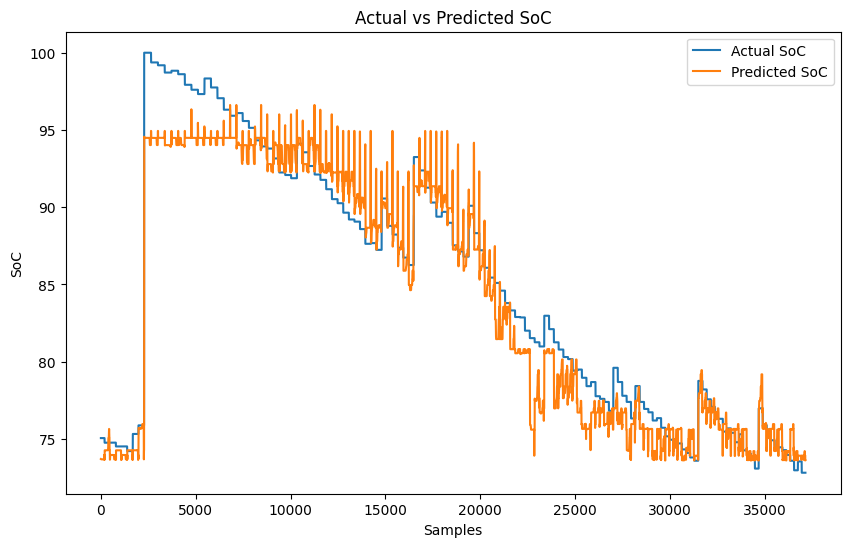

In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Function to create sequences for time-series data
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Extract features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values

y = data['SoC'].values  # State of Charge (SoC) is now the target variable

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define time steps and create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Split into training and validation sets
train_size = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

# Build the model with improved architecture
model = models.Sequential()

# CNN Layer 1
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(0.4))

# CNN Layer 2
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.Dropout(0.4))

# CNN Layer 3
model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))
model.add(layers.Dropout(0.4))

# Bidirectional LSTM Layer
model.add(layers.Bidirectional(layers.LSTM(100, return_sequences=False)))
model.add(layers.Dropout(0.5))

# Dense Layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))

# Output Layer
model.add(layers.Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks for learning rate adjustment and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Model - MAE: {mae}")

# Predict with the model
y_pred = model.predict(X_val)

# Evaluate the model performance
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Plot actual vs predicted SoC
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual SoC')
plt.plot(y_pred, label='Predicted SoC')
plt.title('Actual vs Predicted SoC')
plt.xlabel('Samples')
plt.ylabel('SoC')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 411.8722 - mae: 13.0920 - val_loss: 4.7868 - val_mae: 1.7878 - learning_rate: 0.0010
Epoch 2/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 104.0736 - mae: 8.0687 - val_loss: 4.1945 - val_mae: 1.5907 - learning_rate: 0.0010
Epoch 3/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 85.2582 - mae: 7.2898 - val_loss: 7.6380 - val_mae: 2.1920 - learning_rate: 0.0010
Epoch 4/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - loss: 68.4188 - mae: 6.5092 - val_loss: 6.5491 - val_mae: 2.1703 - learning_rate: 0.0010
Epoch 5/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 61.6337 - mae: 6.1996 - val_loss: 3.2964 - val_mae: 1.3262 - learning_rate: 5.0000e-04
Epoch 6/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 58.6485 - mae: 6.0482 - val_loss: 2.2423 - val_mae: 1.1897 - learning_rate: 5.0000e-04
Epoch 7/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 56.3197 - mae: 5.9232 - val_loss: 1.8526 - val_mae

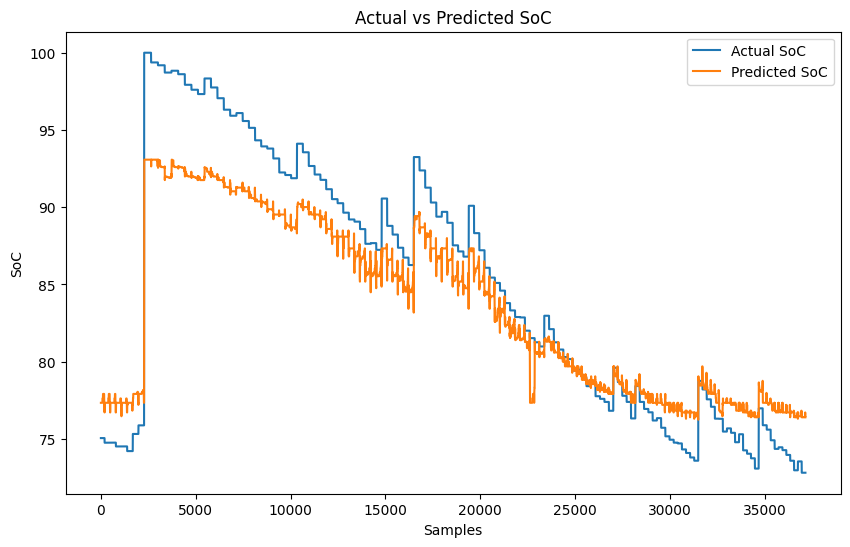

In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Function to create sequences for time-series data
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])  # Use the SoC of the last time step in the sequence
    return np.array(X), np.array(y)

# Extract features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['SoC'].values  # State of Charge (SoC) is the target variable

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define time steps and create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Split into training and validation sets
train_size = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

# Build CNN-LSTM model with 2 CNN layers and reduced LSTM units
cnn_lstm_model = Sequential()

# CNN Layer 1
cnn_lstm_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# CNN Layer 2
cnn_lstm_model.add(Conv1D(128, kernel_size=3, activation='relu'))
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# Bidirectional LSTM Layer with fewer units
cnn_lstm_model.add(Bidirectional(LSTM(50, return_sequences=False)))  # Reduced units
cnn_lstm_model.add(Dropout(0.4))

# Dense Layer
cnn_lstm_model.add(Dense(64, activation='relu'))  # Reduced units
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# Output Layer
cnn_lstm_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
cnn_lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks for learning rate adjustment and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)  # Reduced patience
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Reduced patience

# Train the CNN-LSTM model
cnn_lstm_model.fit(
    X_train, y_train,
    epochs=15,  # Reduced epochs
    batch_size=32,  # Kept batch size
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Extract CNN features
cnn_features_train = cnn_lstm_model.predict(X_train)
cnn_features_val = cnn_lstm_model.predict(X_val)

# Reshape the CNN features to be used by XGBoost
cnn_features_train_reshaped = cnn_features_train.reshape(cnn_features_train.shape[0], -1)
cnn_features_val_reshaped = cnn_features_val.reshape(cnn_features_val.shape[0], -1)

# Train the XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=10)

xg_reg.fit(cnn_features_train_reshaped, y_train)

# Predict with XGBoost model
y_pred_xgboost = xg_reg.predict(cnn_features_val_reshaped)

# Evaluate the model performance
mse = mean_squared_error(y_val, y_pred_xgboost)
mae = mean_absolute_error(y_val, y_pred_xgboost)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_xgboost)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Plot actual vs predicted SoC
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual SoC')
plt.plot(y_pred_xgboost, label='Predicted SoC')
plt.title('Actual vs Predicted SoC')
plt.xlabel('Samples')
plt.ylabel('SoC')
plt.legend()
plt.show()


Epoch 1/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 3716.0974 - mae: 55.5267
Epoch 2/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 818.3008 - mae: 14.6894
Epoch 3/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 542.4197 - mae: 7.0867
Epoch 4/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 540.9914 - mae: 6.8436
Epoch 5/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 541.1360 - mae: 6.7878
Epoch 6/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 541.0670 - mae: 6.6929
Epoch 7/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 541.2051 - mae: 6.6186
Epoch 8/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 540.5329 - mae: 6.5920
Epoch 9/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 540.1793 - mae: 6.5747
Epoch 10/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 541.2130 - mae: 6.5626
Epoch 11/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 540.7632 - mae: 6.5499
Epoch 12/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 20s 5m

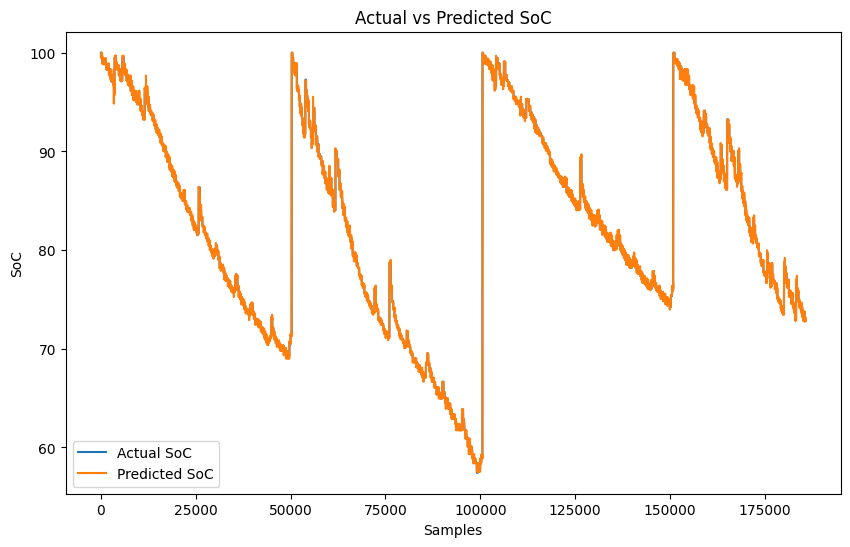

In [59]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Prepare your features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power',
            'Temperature Deviation', 'Time']
X = data[features].values

y = data['SoC'].values  # Predicting SoC (State of Charge) instead of RUL

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define sequence length
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    layers.Input(shape=(time_steps, X_seq.shape[2])),

    # CNN layers
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),

    # LSTM layer
    layers.LSTM(64, return_sequences=False),

    # Dense layer to flatten output for XGBoost
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
])

cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model
#early_stopping = layers.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
#cnn_lstm_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

from keras.callbacks import EarlyStopping  # Correct import

# Fit the model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
cnn_lstm_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)


# Extract CNN-LSTM features for XGBoost
X_cnn_lstm_features = cnn_lstm_model.predict(X_seq)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_cnn_lstm_features, y_seq)

# Predict SoC
y_pred = xgb_model.predict(X_cnn_lstm_features)

# Evaluate model
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)

print(f'Mean Absolute Error (MAE) for SoC prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# Plot Actual vs Predicted SoC
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual SoC')
plt.plot(y_pred, label='Predicted SoC')
plt.title('Actual vs Predicted SoC')
plt.xlabel('Samples')
plt.ylabel('SoC')
plt.legend()
plt.show()


Epoch 1/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 748.1148 - mae: 14.0927
Epoch 2/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 1.5229 - mae: 0.8291
Epoch 3/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.9056 - mae: 0.6112
Epoch 4/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.6251 - mae: 0.5073
Epoch 5/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.5384 - mae: 0.4560
Epoch 6/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.5098 - mae: 0.4226
Epoch 7/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.4441 - mae: 0.3787
Epoch 8/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.4035 - mae: 0.3657
Epoch 9/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.3444 - mae: 0.3373
Epoch 10/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.3833 - mae: 0.3435
Epoch 11/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.3069 - mae: 0.3061
Epoch 12/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.3132 

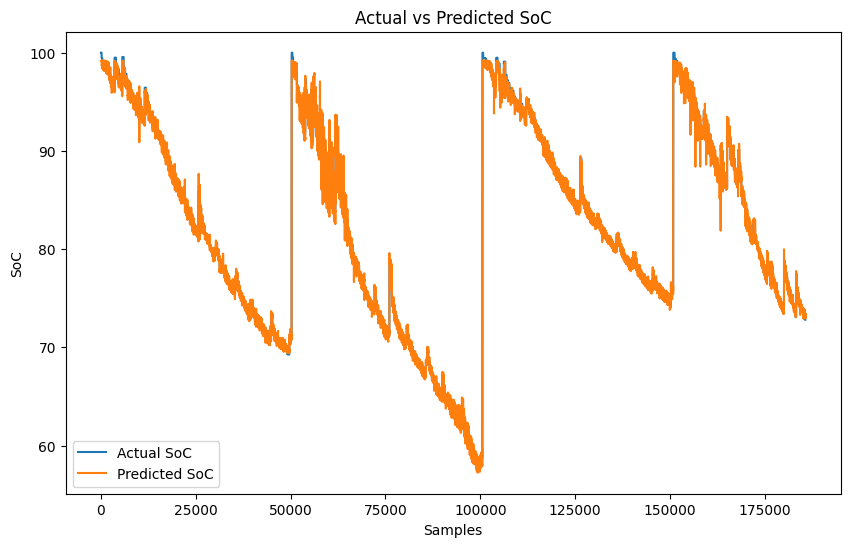

In [60]:
# Function to create sequences for time-series prediction
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Feature extraction using FFT (Fourier Transform)
def extract_fourier_features(signal):
    """Extract features using FFT."""
    fft_result = fft(signal)
    fft_abs = np.abs(fft_result)
    fft_freq = np.fft.fftfreq(len(signal))
    # Keep only the positive frequencies
    positive_freq = fft_freq[:len(fft_freq)//2]
    positive_abs = fft_abs[:len(fft_freq)//2]

    # Extract common frequency-domain features
    mean_freq = np.mean(positive_abs)
    std_freq = np.std(positive_abs)
    max_freq = np.max(positive_abs)
    dominant_freq = positive_freq[np.argmax(positive_abs)]

    return [mean_freq, std_freq, max_freq, dominant_freq]

# Feature extraction using Wavelet Transform (WT)
def extract_wavelet_features(signal):
    """Extract features using Wavelet Transform."""
    coeffs = pywt.wavedec(signal, 'db4', level=min(4, pywt.dwt_max_level(len(signal), pywt.Wavelet('db4'))))
    # Extract features from the wavelet coefficients
    wavelet_features = []
    for coeff in coeffs:
        wavelet_features.append(np.mean(coeff))
        wavelet_features.append(np.std(coeff))
        wavelet_features.append(np.max(coeff))
    return wavelet_features

# Extract features from each column (Voltage, Current, Temperature, etc.) in the dataset
def extract_all_features(data, features, time_steps):
    all_features = []
    for i in range(len(data) - time_steps):  # Loop to form sequences of time_steps length
        feature_vector = []
        for feature in features:
            signal = data[feature].iloc[i:i + time_steps].values  # Extract the time-series for each feature
            # Extract FFT and Wavelet features for the signal
            fft_features = extract_fourier_features(signal)
            wavelet_features = extract_wavelet_features(signal)
            feature_vector.extend(fft_features + wavelet_features)  # Combine both feature sets
        all_features.append(feature_vector)
    return np.array(all_features)

# Assuming `data` is your DataFrame containing the features like Voltage, Current, etc.
# And `features` is a list of feature column names
features = ['Voltage', 'Current', 'Temperature',
            'Current Load', 'Voltage Load','Capacity',
            'Discharge Rate', 'Energy','Battery Impedance', 'Power', 'Time']

# Normalize the features
scaler = StandardScaler()

# Extract features and target variable (SoC)
time_steps = 10  # Sequence length
X_features = extract_all_features(data, features, time_steps=time_steps)  # Extract features for SoC
X_scaled = scaler.fit_transform(X_features)  # Normalize the features

# Target variable (SoC values)
y = data['SoC'].values[time_steps:]  # Ensure correct target indexing

# Create sequences (X_seq) and targets (y_seq)
X_seq, y_seq = create_sequences(X_scaled, y, time_steps=time_steps)

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    layers.Input(shape=(X_seq.shape[1], X_seq.shape[2])),

    # CNN layers
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),

    # LSTM layer
    layers.LSTM(64, return_sequences=False),

    # Dense layer
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer for SoC prediction
])

cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
cnn_lstm_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

# Predict SoC with CNN-LSTM
y_cnn_lstm_pred = cnn_lstm_model.predict(X_seq)

# Evaluate model
mae = mean_absolute_error(y_seq, y_cnn_lstm_pred)
mse = mean_squared_error(y_seq, y_cnn_lstm_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_cnn_lstm_pred)

print(f'Mean Absolute Error (MAE) for SoC prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# Plot Actual vs Predicted SoC
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual SoC')
plt.plot(y_cnn_lstm_pred, label='Predicted SoC')
plt.title('Actual vs Predicted SoC')
plt.xlabel('Samples')
plt.ylabel('SoC')
plt.legend()
plt.show()


5804/5804 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Mean Absolute Error (MAE) for SoC prediction: 0.2779998183262667
Mean Squared Error (MSE): 0.14296638886445676
Root Mean Squared Error (RMSE): 0.3781089642741319
R² (Coefficient of Determination): 0.9986992462878026


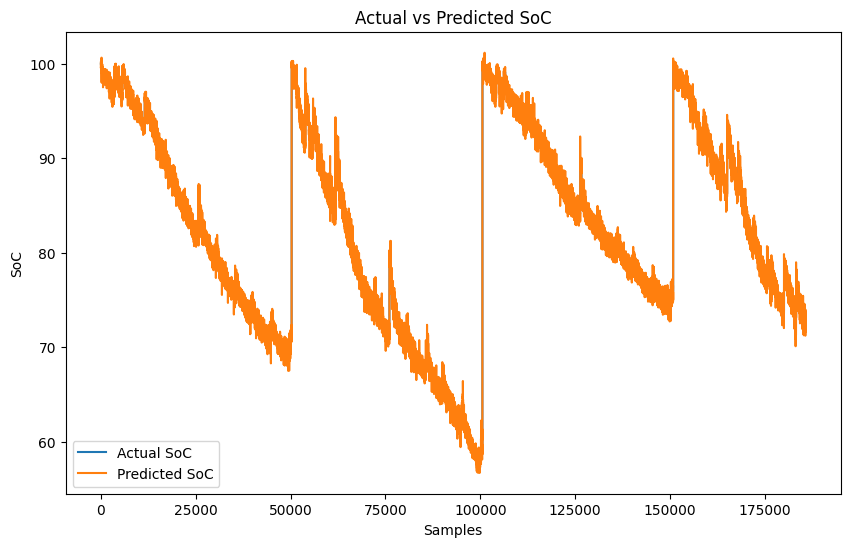

In [61]:
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# Function to create sequences for time-series prediction
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Feature extraction using RNN
def extract_rnn_features(X_seq):
    # Define RNN Model
    rnn_model = Sequential([
        layers.Input(shape=(X_seq.shape[1], X_seq.shape[2])),  # Input shape
        layers.SimpleRNN(64, activation='relu', return_sequences=False),  # RNN layer
        layers.Dense(32, activation='relu'),  # Dense layer to extract features
    ])

    # Extract features
    rnn_features = rnn_model.predict(X_seq)
    return rnn_features

# Assuming `data` is your DataFrame containing the features like Voltage, Current, etc.
features = ['Voltage', 'Current', 'Temperature', 'Capacity', 'SoC', 'Discharge Rate', 'Energy']
X = data[features].values
y = data['SoC'].values  # Target variable: State of Charge (SoC)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define sequence length
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

# Extract RNN features
rnn_features = extract_rnn_features(X_seq)

# Train XGBoost model on the extracted RNN features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(rnn_features, y_seq)  # Train with RNN features

# Predict SoC using XGBoost
y_pred = xgb_model.predict(rnn_features)

# Evaluate model
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)

print(f'Mean Absolute Error (MAE) for SoC prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# Plot Actual vs Predicted SoC
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual SoC')
plt.plot(y_pred, label='Predicted SoC')
plt.title('Actual vs Predicted SoC')
plt.xlabel('Samples')
plt.ylabel('SoC')
plt.legend()
plt.show()
